In [1]:
import warnings

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

# %%
import SpaCross as TOOLS

from scipy.sparse import csr_matrix

In [2]:
with open('../Config/MOB.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [3]:
def load_adata(top_genes=10000, section_name=['Stereo', 'Slide']):
    Batch_list = []
    data_root = Path('D:/project/datasets/Dataset1_LiuLongQi_MouseOlfactoryBulb/raw')
    for slice_id, name in enumerate(section_name):
        name = 'MOB_'+name+'.h5ad'
        adata = sc.read(data_root / name)
        adata.var_names_make_unique()
        adata.layers['count'] = adata.X
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=top_genes)
        adata = adata[:, adata.var['highly_variable'] == True]
        sc.pp.scale(adata)
        adata.obs['slice_id'] = slice_id
        Batch_list.append(adata)
    return Batch_list

In [4]:
section_name=['Stereo', 'Slide']
top_genes=10000
Batch_list = load_adata(top_genes, section_name)

In [5]:
config['data']['k_cutoff']=12

In [6]:
adata, edge_index = TOOLS.graph_construction3D(Batch_list, section_ids=section_name, k_cutoff=config['data']['k_cutoff'], rad_cutoff=None, mode='KNN', slice_dist_micron=[1000], coor_key='spatial')
adata

Start building a graph...
Radius for graph connection is 7.8148.
The graph contains 470976 edges, 39248 cells.
12.0000 neighbors per cell on average.


AnnData object with n_obs × n_vars = 39248 × 3958
    obs: 'slice_id', 'slice_name'
    obsm: 'spatial', 'loc'
    layers: 'count'

In [7]:
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X
adata

AnnData object with n_obs × n_vars = 39248 × 3958
    obs: 'slice_id', 'slice_name'
    obsm: 'spatial', 'loc', 'X_pca'
    layers: 'count'

In [8]:
config['train']['topk_neighs'] = 15
config['train']['topk_neighs_inter'] = 30

In [9]:
num_clusters = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TOOLS.SC_BC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)
# %%
net.trian()
# %%
enc_rep, recon = net.process()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
# %%

Epoch 299 total loss=1.183 recon loss=1.065 mean loss=0.405 tri loss=1.388: 100%|██████████| 300/300 [02:19<00:00,  2.15it/s]


In [10]:
# %%
adata.obs["mclust"] = TOOLS.clustering(z=enc_rep, n_clust=8, num_seed=1, method="mclust")
adata.obs['label'] = adata.obs["mclust"]

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


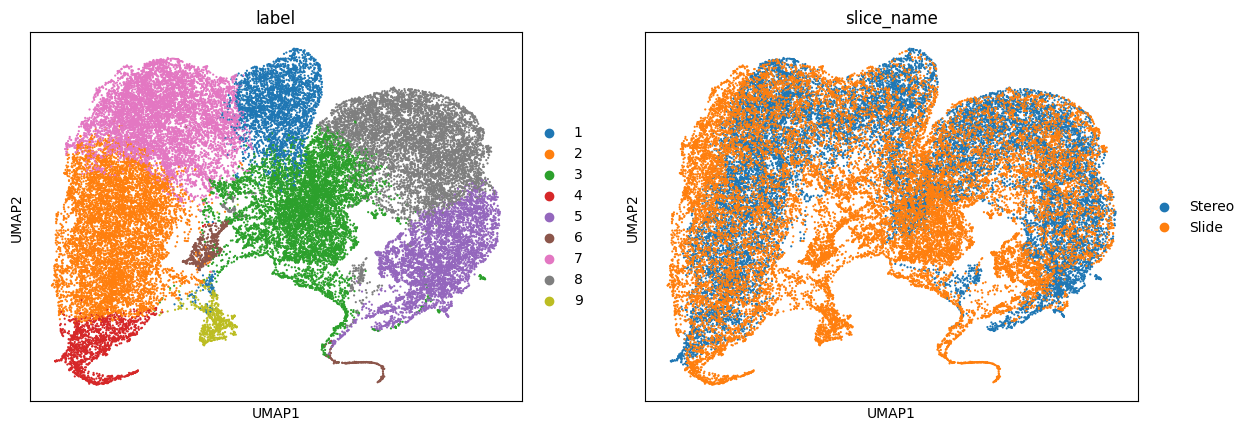

In [11]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['label', 'slice_name'], show=True, size=10, save=False)

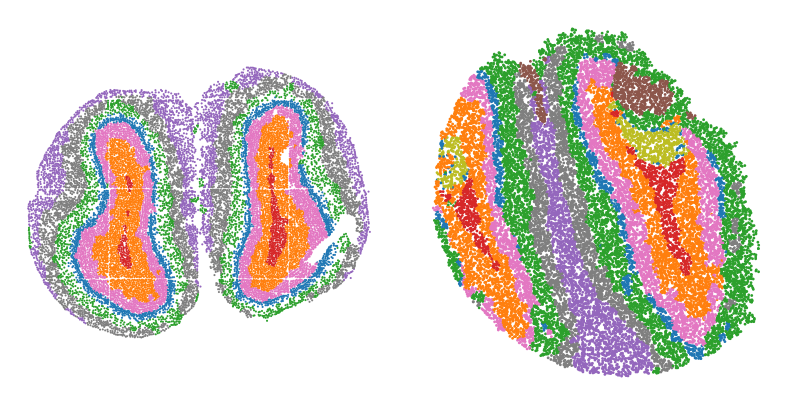

In [12]:
spot_size = 35
title_size = 12
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(section_name):
    sub_adata = adata[adata.obs['slice_name'] == name]
    _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['label'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
plt.show()

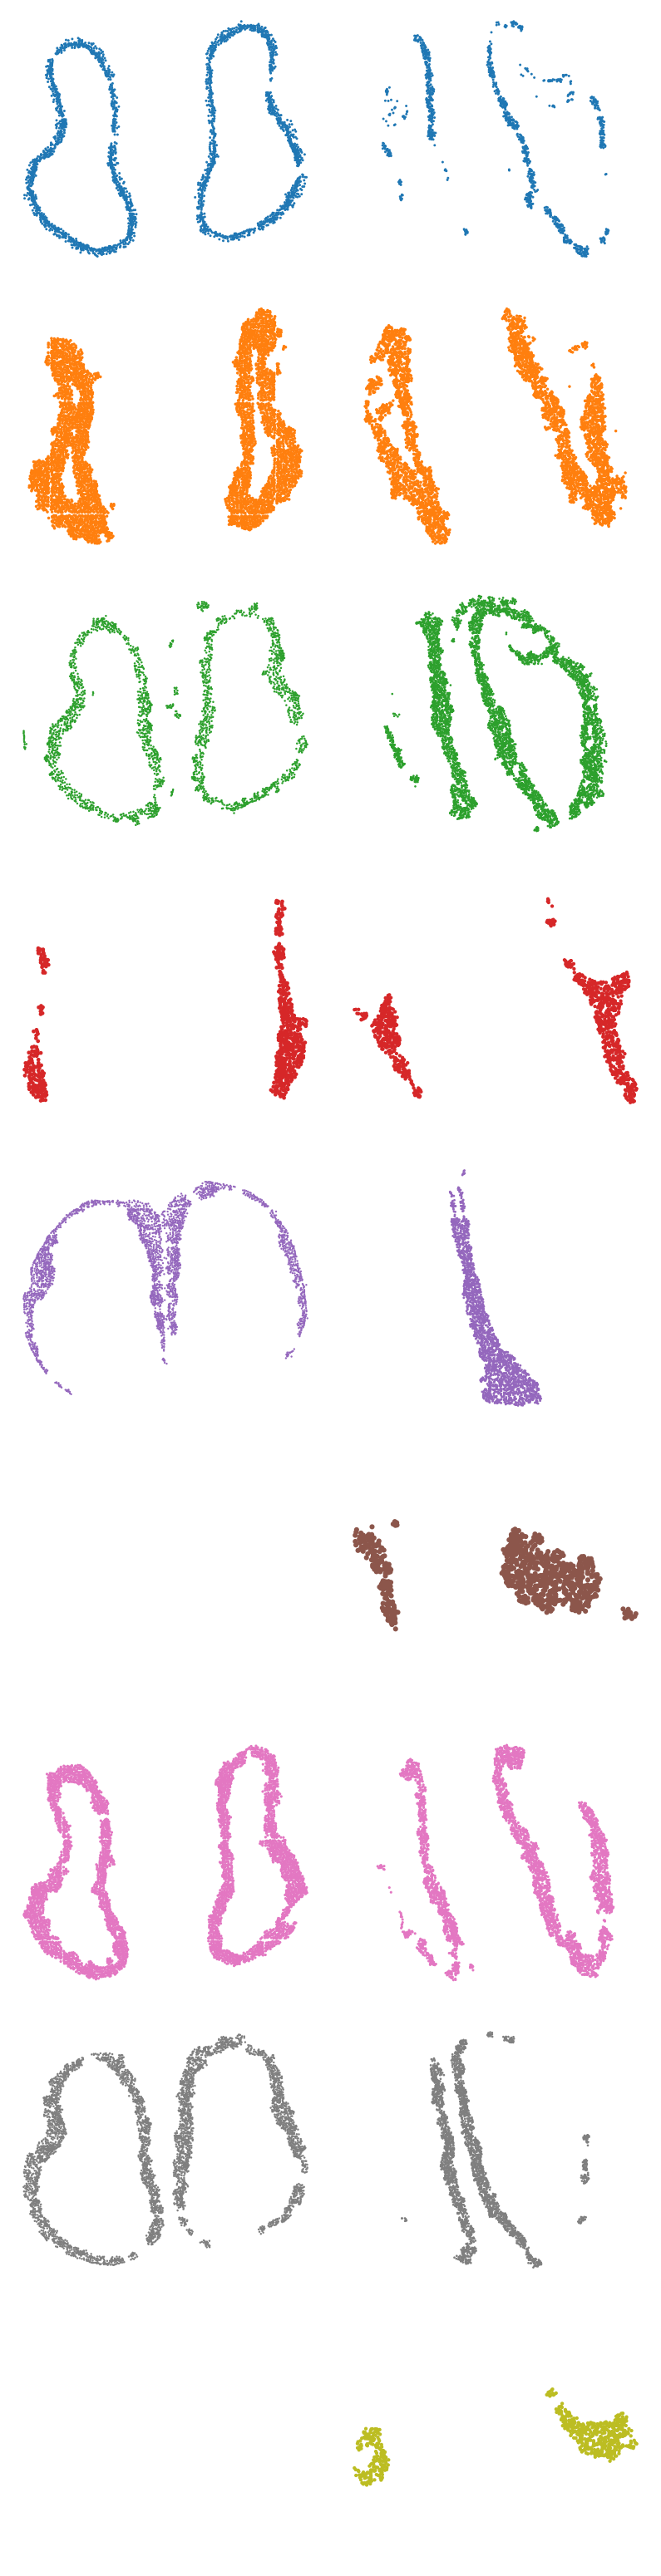

In [13]:
spot_size = 40
title_size = 12 
fig, ax = plt.subplots(9, 2, figsize=(10, 40), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
kkk = 0
for domain in ['1','2','3','4','5','6','7','8','9']:
    for idx, name in enumerate(section_name):
        sub_adata = adata[adata.obs['slice_name'] == name]
        sub_adata = sub_adata[sub_adata.obs['label']==domain]
        _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['label'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[kkk, idx], frameon=False,
                          spot_size=spot_size)
    kkk += 1
plt.show()